In [1]:
import os, sys
import attr
# add to path
sys.path.append("../..")

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from PIL import Image
seaborn.set()

In [2]:

from filterflow.smc import SMC
from filterflow.base import State, InputsBase, StateSeries, DTYPE_TO_OBSERVATION_SERIES

from filterflow.observation.linear import LinearObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal.base import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard.systematic import SystematicResampler
from filterflow.resampling.standard.multinomial import MultinomialResampler

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

In [3]:
observation_dim = 2
state_dim = 2
T = 150
initial_state          = np.repeat(0., state_dim)
transition_matrix      = np.eye(state_dim) * 0.5
transition_covariance  = np.eye(state_dim) * 0.5

observation_matrix     = np.eye(observation_dim) *0.5
observation_covariance = np.eye(observation_dim)*0.1

In [4]:
tf_observation_matrix = tf.constant(observation_matrix, dtype = tf.float32)
tf_observation_covariance = tf.constant(observation_covariance, dtype = tf.float32)


tf_transition_matrix = tf.constant(transition_matrix, dtype = tf.float32)
tf_transition_covariance =  tf.constant(transition_covariance, dtype = tf.float32)

In [5]:
# Transition
state_dim = tf_transition_covariance.shape.as_list()[0]
transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                                    tf_transition_covariance)

transition_model = RandomWalkModel(tf_transition_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., state_dim), dtype=tf.float32), 
                                                             tf_observation_covariance)
observation_model = LinearObservationSampler(tf_observation_matrix, observation_error)

In [6]:
## State space model
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
initial_particle = tf.constant(np.random.random(state_dim), dtype = tf.float32)
states, observations = ss_model(initial_particle, T)

In [7]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

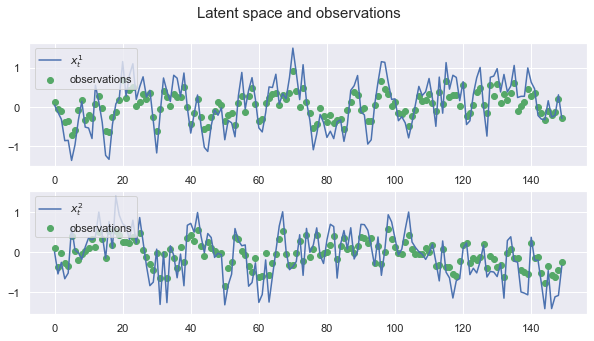

In [8]:
linspace  = np.arange(np_obs[:,0].shape[0])
fig, axes = plt.subplots(nrows=2, figsize=(10, 5))
axes[0].scatter(linspace, np_obs[:,0], marker='o', color='g', label='observations')
axes[0].plot(np_states[:, 0], color='b', label='$x^1_t$')
axes[1].plot(np_states[:, 1], color='b', label='$x^2_t$')
axes[1].scatter(linspace, np_obs[:,1], marker='o', color='g', label='observations')
_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')
_ = fig.suptitle('Latent space and observations', fontsize=15)

In [9]:
# store observations
batch_size = 1
n_particles = 1000
dimension = 2

resampling_criterion = NeverResample()
resampling_method = NoResampling()

weights = tf.ones((batch_size, n_particles), dtype=float)/tf.cast(n_particles, float)
initial_particles = tf.random.uniform((batch_size, n_particles, dimension), -1, 1)
log_likelihoods = tf.zeros((batch_size), dtype=float)
initial_state = State(particles=initial_particles, log_weights= tf.math.log(weights), weights=weights, log_likelihoods=log_likelihoods)



In [10]:
observations_list = observations

In [11]:
obs_data = tf.data.Dataset.from_tensor_slices(observations_list)

In [12]:
init_g_matrix = np.eye(2)
init_g_cov = np.eye(2)

init_f_matrix = np.eye(2)
init_f_cov = np.eye(2)

g_matrix = tf.Variable(init_g_matrix, dtype = tf.float32, trainable = True)
g_covariance = tf.Variable(init_g_cov, dtype = tf.float32, trainable = True)


f_matrix = tf.Variable(init_f_matrix, dtype = tf.float32, trainable = True)
f_covariance =  tf.Variable(init_f_cov, dtype = tf.float32, trainable = True)

# Create an optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.05)


transition_noise = tfd.MultivariateNormalTriL(tf.constant(np.repeat(0., 2), dtype=tf.float32), 
                                                                f_covariance)
transition_model = RandomWalkModel(f_matrix, transition_noise)

# Observation
observation_error = tfp.distributions.MultivariateNormalTriL(tf.constant(np.repeat(0., 2), dtype=tf.float32), 
                                                         g_covariance)
observation_model = LinearObservationSampler(g_matrix, observation_error)

# proposal
proposal_model = BootstrapProposalModel(transition_model)

# particle filter
particle_filter = SMC(observation_model, transition_model, 
                                          proposal_model, resampling_criterion, resampling_method)
        
        

In [53]:
# observation_series = tf.stack(observations_list)

observation_series = tf.data.Dataset.from_tensor_slices(observations_list)

In [61]:
tf.function
def loss_func():
    final_state = particle_filter(initial_state, observation_series=observation_series, return_final = True)
    return -final_state.log_likelihoods / T

In [62]:
tf.function
def train_one_step(optimizer, f_matrix, f_covariance, g_matrix, g_covariance):
    with tf.GradientTape() as tape:
        var_list= [f_matrix, f_covariance, g_matrix, g_covariance]
        # tape.watch(var_list)
        loss = loss_func2()
        grads = tape.gradient(loss, var_list)
    
    # apply gradients    
    #optimizer.apply_gradients(zip(grads,var_list))

    return loss, grads

tf.function
def train(optimizer, f_matrix, f_covariance, g_matrix, g_covariance, num_steps = 100):
    for step in range(num_steps):
        loss, grads = train_one_step(optimizer, f_matrix, f_covariance, g_matrix, g_covariance)
        if step % 10 == 0:
            tf.print('Step', step, ': loss', loss)
            tf.print('grads', grads)
            

In [63]:
train(optimizer, f_matrix, f_covariance, g_matrix, g_covariance, num_steps=100)

TypeError: in converted code:

    ../..\filterflow\smc.py:107 return_final_loop  *
        for t, observation in enumerate(observation_series):
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\autograph\operators\control_flow.py:324 for_stmt
        composite_symbol_names)
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\autograph\operators\control_flow.py:567 _tf_dataset_for_stmt
        composite_symbol_names)
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\autograph\operators\control_flow.py:691 _dataset_for_stmt_no_extra_test
        ds = _general_purpose_scan(ds, aug_vars, scan_body)
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\autograph\operators\control_flow.py:581 _general_purpose_scan
        return scan_ops._ScanDataset(ds, init_state, body, use_default_device=False)  # pylint:disable=protected-access
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\data\experimental\ops\scan_ops.py:40 __init__
        self._initial_state = structure.normalize_element(initial_state)
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\data\util\structure.py:114 normalize_element
        return nest.pack_sequence_as(element, normalized_components)
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\data\util\nest.py:191 pack_sequence_as
        _, packed = _packed_nest_with_indices(structure, flat_sequence, 0)
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\data\util\nest.py:148 _packed_nest_with_indices
        new_index, child = _packed_nest_with_indices(s, flat, index)
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\data\util\nest.py:148 _packed_nest_with_indices
        new_index, child = _packed_nest_with_indices(s, flat, index)
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\data\util\nest.py:146 _packed_nest_with_indices
        for s in _yield_value(structure):
    c:\users\james\documents\oxford\filterflow\venv\lib\site-packages\tensorflow_core\python\data\util\nest.py:93 _yield_value
        for value in iterable:

    TypeError: 'State' object is not iterable


In [16]:
final_state = particle_filter(initial_state, observation_series=observation_series)